Importing necessity libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

# !pip install eli5
import eli5


from sklearn import metrics
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

First we look at what the data looks like

In [2]:
df = pd.read_csv('ARM_Cars.csv')
df.head()

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color
0,1200,VAZ(Lada) 2115,12.11.2019,2001,157000.0,Sedan,Manual,Left,Blue
1,1200,BMW 316,14.11.2019,1993,25000.0,Sedan,Manual,Left,Green
2,1200,VAZ(Lada) 2108,20.11.2019,1987,165000.0,Coupe,Manual,Left,Gray
3,1200,ErAZ 3218,30.11.2019,1992,80000.0,Estate,Manual,Left,Blue
4,1200,Chevrolet Cruze,19.11.2019,2002,120000.0,Hatchback,Automatic,Right,Silver


In [3]:
df.shape

(8545, 9)

In [4]:
df.describe()

,Price ($),Year,Mileage
count,8545.000000,8545.000000,8545.000000
mean,9776.411001,2006.778350,152626.466202
std,9020.462272,5.565916,69769.923186
min,1200.000000,1961.000000,3000.000000
25%,4700.000000,2003.000000,103040.000000
50%,7600.000000,2007.000000,148000.000000
75%,11500.000000,2011.000000,194000.000000
max,200000.000000,2020.000000,470000.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8545 entries, 0 to 8544
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price ($)         8545 non-null   int64  
 1   Car               8545 non-null   object 
 2   Date Posted       8545 non-null   object 
 3   Year              8545 non-null   int64  
 4   Mileage           8545 non-null   float64
 5   Vehicle Type      8545 non-null   object 
 6   Transmission      8545 non-null   object 
 7   Wheel left/right  8545 non-null   object 
 8   Color             8545 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 600.9+ KB


In [6]:
df.isnull().sum()

Price ($)           0
Car                 0
Date Posted         0
Year                0
Mileage             0
Vehicle Type        0
Transmission        0
Wheel left/right    0
Color               0
dtype: int64

In [7]:
df = df.drop_duplicates()

In [8]:
for col in df.columns:
  print('Unique value count of', col, 'is', len(df[col].unique()))

Unique value count of Price ($) is 482
Unique value count of Car is 583
Unique value count of Date Posted is 26
Unique value count of Year is 44
Unique value count of Mileage is 1187
Unique value count of Vehicle Type is 10
Unique value count of Transmission is 4
Unique value count of Wheel left/right is 3
Unique value count of Color is 18


In [9]:
df['Wheel left/right'].value_counts()

Left            8105
Right            353
Changed l->R      82
Name: Wheel left/right, dtype: int64

In [10]:
df['Color'].value_counts()

Black          2964
White          2069
Silver         1458
Gray            634
Blue            583
Other Color     183
Green           161
Red             132
Gold             98
Cherry           66
Beige            58
Brown            50
Azure            39
Yellow           15
Eggplant         14
Purple            8
Orange            7
Pink              1
Name: Color, dtype: int64

In [11]:
df['Transmission'].value_counts()

Automatic         6526
Manual            1752
Variator           209
Semi-Automatic      53
Name: Transmission, dtype: int64

In [12]:
df['Vehicle Type'].value_counts()

Sedan                      4312
SUV                        1523
MPV                         814
Hatchback                   782
Estate                      778
Coupe                       203
Van                          88
Pickup                       25
Convertible or Roadster      13
Limousine                     2
Name: Vehicle Type, dtype: int64

Let's see if there are any outliers, if yes remove them

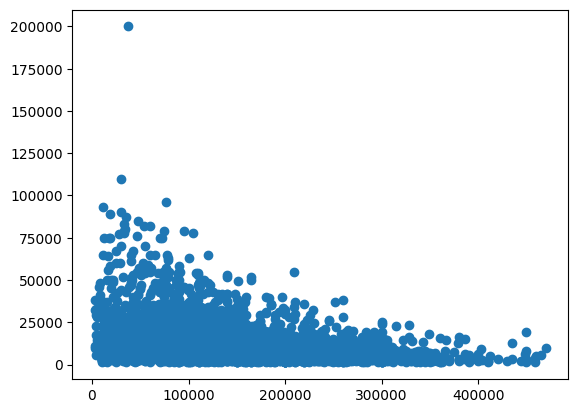

In [13]:
plt.scatter(df['Mileage'], df['Price ($)'])
plt.show()

Here we notice that there is a point separated from the data. Now we will look at the rest of his features and understand if it is worth considering him an outlier

In [14]:
outlier = df[df['Price ($)'] >= 125000]
outlier

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color
8544,200000,Rolls Royce Wraith,13.11.2019,2014,37000.0,Coupe,Automatic,Left,Eggplant


In [15]:
df = df[df['Price ($)'] <= 125000]
df.shape

(8539, 9)

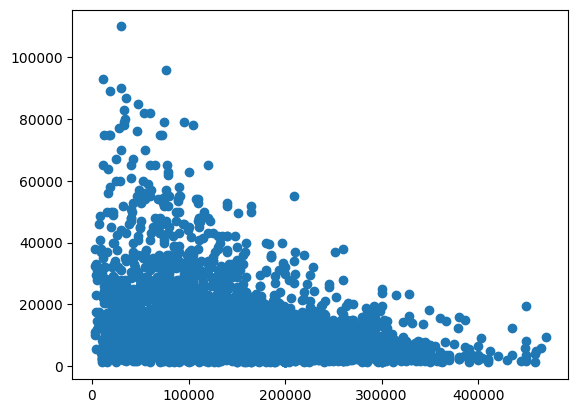

In [16]:
plt.scatter(df['Mileage'], df['Price ($)'])
plt.show()

Text(0.5, 1.0, 'Car Price Histogram')

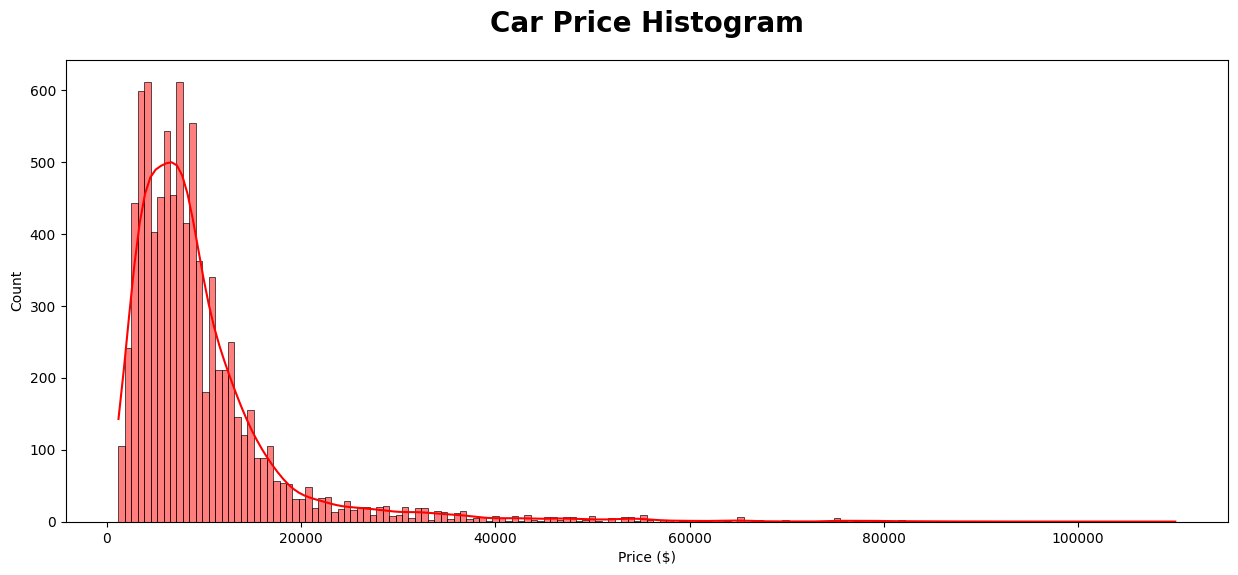

In [17]:
plt.figure(figsize=(15,6))
sns.histplot(df["Price ($)"],color="red",kde=True)
plt.title("Car Price Histogram",fontweight="black",pad=20,fontsize=20)

The resulting plot shows the distribution of prices in the data. As we can see, the graph is skewed, this means that there are more cheap cars than expensive cars.

In [18]:
print('Mean:',df['Price ($)'].mean())
print('Median:',df['Price ($)'].median())
print('Standard Deviation:',df['Price ($)'].std())
print('Variance:',df['Price ($)'].var())

Mean: 9753.382363274388
Median: 7600.0
Standard Deviation: 8784.003160269696
Variance: 77158711.51962802


Because the Mean and Median are not close, the data is skewed, as seen in the histogram above. There is a large variance in the data.

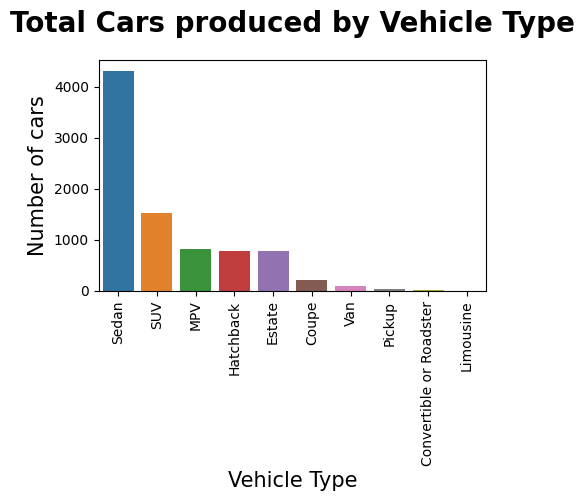

In [19]:
plt.figure(figsize=(5,3))
counts = df["Vehicle Type"].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Vehicle Type",fontsize=15)
plt.ylabel("Number of cars",fontsize=15)
plt.title("Total Cars produced by Vehicle Type", pad=20, fontweight="black", fontsize=20)
plt.xticks(rotation=90)
plt.show()

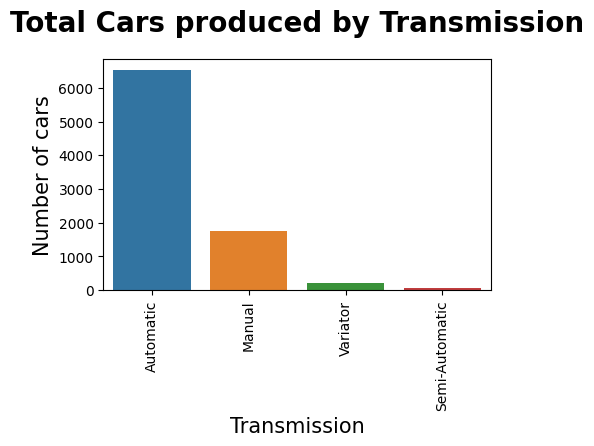

In [20]:
plt.figure(figsize=(5,3))
counts = df["Transmission"].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel("Transmission",fontsize=15)
plt.ylabel("Number of cars",fontsize=15)
plt.title("Total Cars produced by Transmission", pad=20, fontweight="black", fontsize=20)
plt.xticks(rotation=90)
plt.show()

C:\Users\davoy\AppData\Local\Temp\ipykernel_15612\1917742013.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_groupby_vehicleType = df.groupby(["Vehicle Type"]).mean()


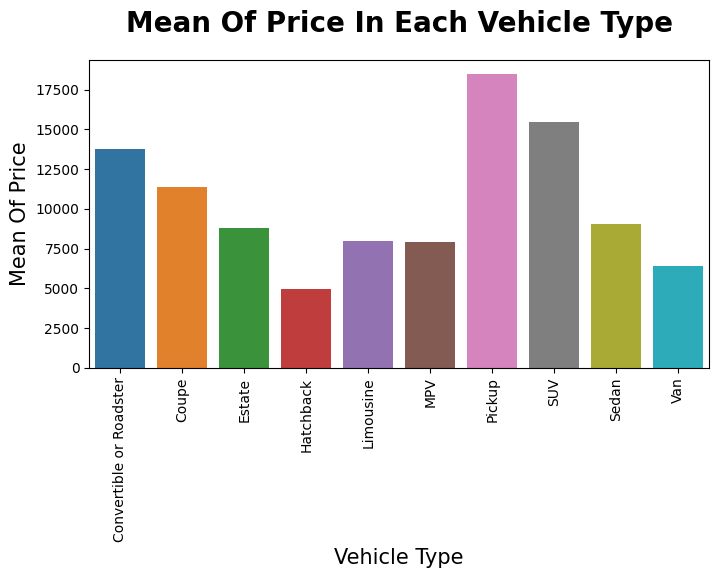

In [21]:
df_groupby_vehicleType = df.groupby(["Vehicle Type"]).mean()
plt.figure(figsize=(8,4))
price_mean = df_groupby_vehicleType['Price ($)']
sns.barplot(x=df_groupby_vehicleType.index, y=price_mean)
plt.xlabel("Vehicle Type",fontsize=15)
plt.ylabel("Mean Of Price",fontsize=15)
plt.title("Mean Of Price In Each Vehicle Type", pad=20, fontweight="black", fontsize=20)
plt.xticks(rotation=90)
plt.show()

C:\Users\davoy\AppData\Local\Temp\ipykernel_15612\2616587735.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_groupby_transmission = df.groupby(["Transmission"]).mean()


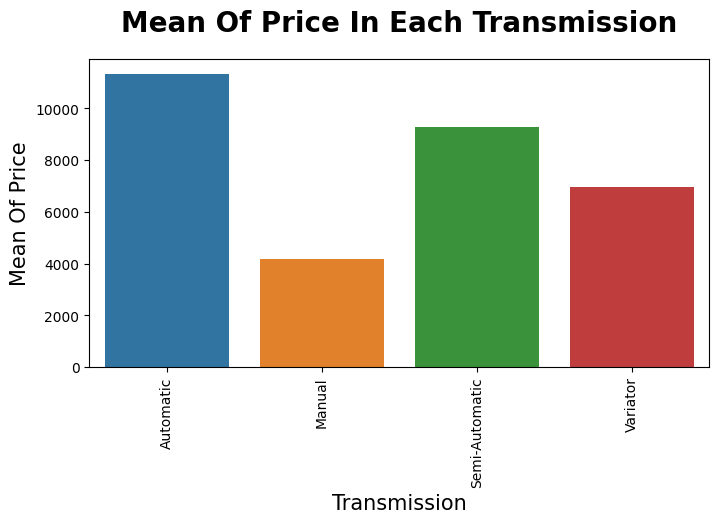

In [22]:
df_groupby_transmission = df.groupby(["Transmission"]).mean()
plt.figure(figsize=(8,4))
price_mean = df_groupby_transmission['Price ($)']
sns.barplot(x=df_groupby_transmission.index, y=price_mean)
plt.xlabel("Transmission",fontsize=15)
plt.ylabel("Mean Of Price",fontsize=15)
plt.title("Mean Of Price In Each Transmission", pad=20, fontweight="black", fontsize=20)
plt.xticks(rotation=90)
plt.show()

We separate Brand and Model from Car as separate attributes to make it easier to use the data we have.

In [23]:
df1 = df

df1[['Brand', 'Model']] = df1['Car'].str.split(' ', 1, expand=True)
df1.head(5)

C:\Users\davoy\AppData\Local\Temp\ipykernel_15612\4144128515.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df1[['Brand', 'Model']] = df1['Car'].str.split(' ', 1, expand=True)


,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
0,1200,VAZ(Lada) 2115,12.11.2019,2001,157000.0,Sedan,Manual,Left,Blue,VAZ(Lada),2115
1,1200,BMW 316,14.11.2019,1993,25000.0,Sedan,Manual,Left,Green,BMW,316
2,1200,VAZ(Lada) 2108,20.11.2019,1987,165000.0,Coupe,Manual,Left,Gray,VAZ(Lada),2108
3,1200,ErAZ 3218,30.11.2019,1992,80000.0,Estate,Manual,Left,Blue,ErAZ,3218
4,1200,Chevrolet Cruze,19.11.2019,2002,120000.0,Hatchback,Automatic,Right,Silver,Chevrolet,Cruze


C:\Users\davoy\AppData\Local\Temp\ipykernel_15612\3744575106.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1_groupby_brand = df.groupby(["Brand"]).mean().sort_values(by='Price ($)', ascending=False)


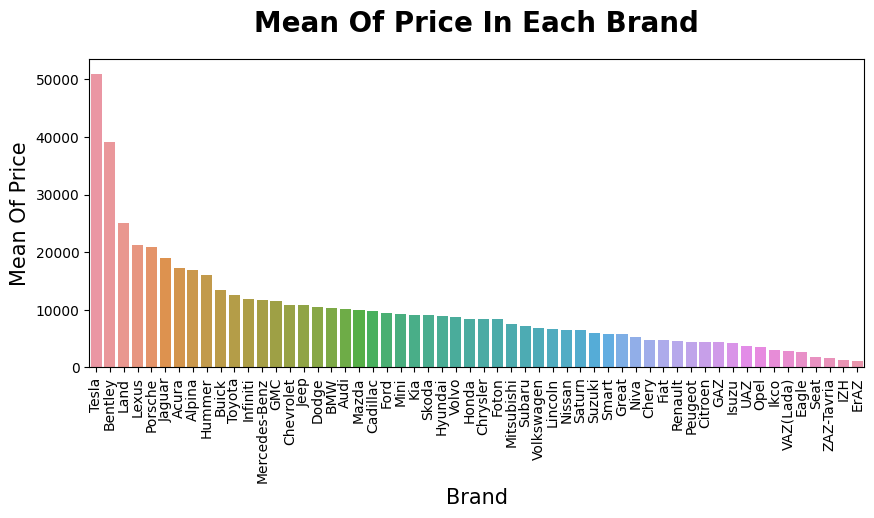

In [24]:
df1_groupby_brand = df.groupby(["Brand"]).mean().sort_values(by='Price ($)', ascending=False)
plt.figure(figsize=(10,4))
price_mean = df1_groupby_brand['Price ($)']
sns.barplot(x=df1_groupby_brand.index, y=price_mean)
plt.xlabel("Brand",fontsize=15)
plt.ylabel("Mean Of Price",fontsize=15)
plt.title("Mean Of Price In Each Brand", pad=20, fontweight="black", fontsize=20)
plt.xticks(rotation=90)
plt.show()

There are  56  brands


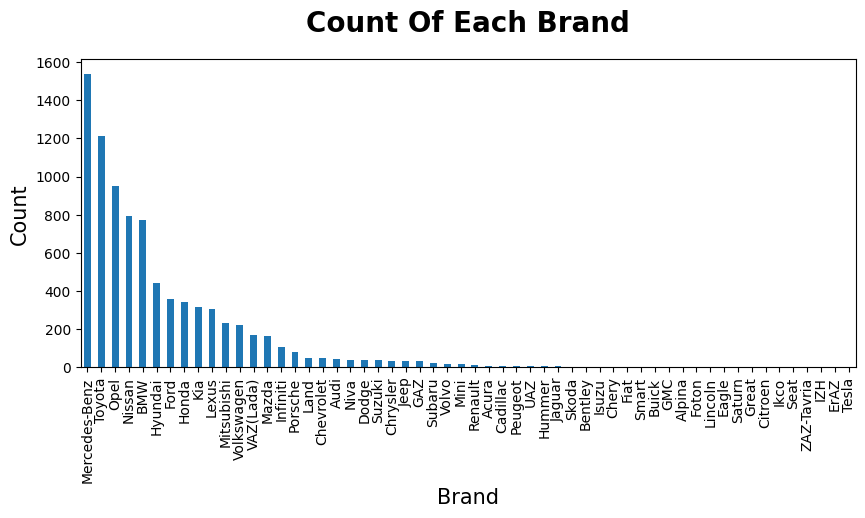

In [25]:
plt.figure(figsize=(10,4))
df['Brand'].value_counts().plot(kind='bar')
plt.xlabel("Brand",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.title("Count Of Each Brand", pad=20, fontweight="black", fontsize=20)
print("There are " ,df['Brand'].nunique(), ' brands')

Since the number of brands is very large, we will continue the research for the first five most popular brands.

Let's look at their price and Mileage dependencies one by one, and if there are any outliers, remove them.

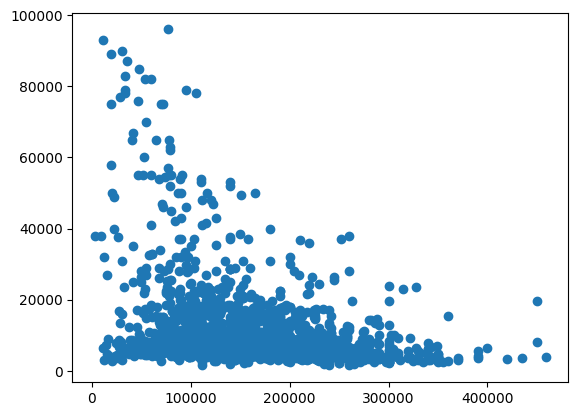

In [26]:
merc_df = df[df['Brand'] == 'Mercedes-Benz']

plt.scatter(merc_df['Mileage'], merc_df['Price ($)'])
plt.show()

In [27]:
merc_df[merc_df['Price ($)'] > 95000]

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
8542,96000,Mercedes-Benz G 63 AMG,02.12.2019,2015,77000.0,SUV,Automatic,Left,Black,Mercedes-Benz,G 63 AMG


Since this item stands out, we look at the rest of the cars in its model to see if it is an outlier.

In [28]:
merc_df[merc_df['Model'] == 'G 63 AMG']

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
8521,75000,Mercedes-Benz G 63 AMG,12.11.2019,2014,72000.0,SUV,Automatic,Left,Black,Mercedes-Benz,G 63 AMG
8525,75000,Mercedes-Benz G 63 AMG,17.11.2019,2013,70000.0,SUV,Automatic,Left,Other Color,Mercedes-Benz,G 63 AMG
8529,78000,Mercedes-Benz G 63 AMG,04.12.2019,2013,33000.0,SUV,Automatic,Left,Black,Mercedes-Benz,G 63 AMG
8531,79000,Mercedes-Benz G 63 AMG,23.11.2019,2013,33000.0,SUV,Automatic,Left,Black,Mercedes-Benz,G 63 AMG
8532,79000,Mercedes-Benz G 63 AMG,20.11.2019,2013,95000.0,SUV,Automatic,Left,Black,Mercedes-Benz,G 63 AMG
8534,82000,Mercedes-Benz G 63 AMG,01.12.2019,2015,60000.0,SUV,Automatic,Left,Black,Mercedes-Benz,G 63 AMG
8537,85000,Mercedes-Benz G 63 AMG,23.11.2019,2015,48000.0,SUV,Automatic,Left,Black,Mercedes-Benz,G 63 AMG
8542,96000,Mercedes-Benz G 63 AMG,02.12.2019,2015,77000.0,SUV,Automatic,Left,Black,Mercedes-Benz,G 63 AMG


There are no outliers here.

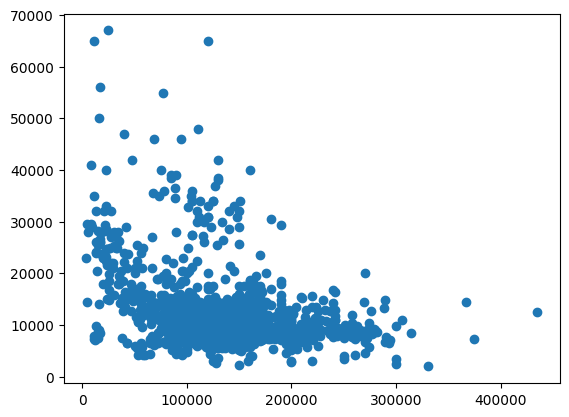

In [29]:
toyota_df = df[df['Brand'] == 'Toyota']

plt.scatter(toyota_df['Mileage'], toyota_df['Price ($)'])
plt.show()


In [30]:
toyota_df[toyota_df['Price ($)'] > 62000]

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
8512,65000,Toyota Camry,16.11.2019,2012,120000.0,Sedan,Automatic,Left,Gray,Toyota,Camry
8514,65000,Toyota Tundra,13.11.2019,2018,11270.0,Pickup,Automatic,Left,White,Toyota,Tundra
8518,67000,Toyota Land Cruiser 200,12.11.2019,2018,25000.0,SUV,Automatic,Left,Black,Toyota,Land Cruiser 200


In [31]:
toyota_df[(toyota_df['Model'] == 'Camry')]

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
2870,5900,Toyota Camry,27.11.2019,2007,99820.0,Sedan,Automatic,Left,Silver,Toyota,Camry
2885,5900,Toyota Camry,20.11.2019,2009,225400.0,Sedan,Automatic,Left,Silver,Toyota,Camry
3073,6200,Toyota Camry,27.11.2019,2011,144900.0,Sedan,Automatic,Left,Red,Toyota,Camry
3130,6300,Toyota Camry,02.12.2019,2006,108000.0,Sedan,Automatic,Left,Black,Toyota,Camry
3340,6500,Toyota Camry,27.11.2019,2006,293020.0,Sedan,Automatic,Left,Black,Toyota,Camry
...,...,...,...,...,...,...,...,...,...,...,...
8288,32000,Toyota Camry,18.11.2019,2018,21000.0,Sedan,Automatic,Left,White,Toyota,Camry
8293,32000,Toyota Camry,28.11.2019,2018,13000.0,Sedan,Automatic,Left,White,Toyota,Camry
8307,33000,Toyota Camry,16.11.2019,2018,23000.0,Sedan,Automatic,Left,Black,Toyota,Camry
8338,35000,Toyota Camry,01.12.2019,2018,11000.0,Sedan,Automatic,Left,Black,Toyota,Camry


There are no outliers here as well.

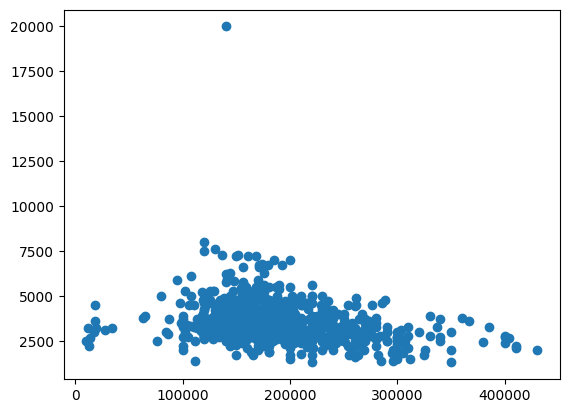

In [32]:
opel_df = df[df['Brand'] == 'Opel']

plt.scatter(opel_df['Mileage'], opel_df['Price ($)'])
plt.show()


In [33]:
opel_df[opel_df['Price ($)'] > 17500]

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
7920,20000,Opel Astra,25.11.2019,2003,140000.0,Sedan,Manual,Left,Red,Opel,Astra


It is clear from the graph that we have one outlier, so we remove it

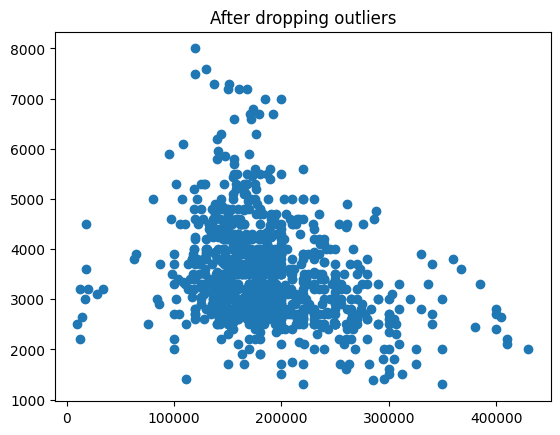

In [34]:
opel_df = opel_df[opel_df['Price ($)'] < 20000]
plt.scatter(opel_df['Mileage'], opel_df['Price ($)'])
plt.title('After dropping outliers')
plt.show()

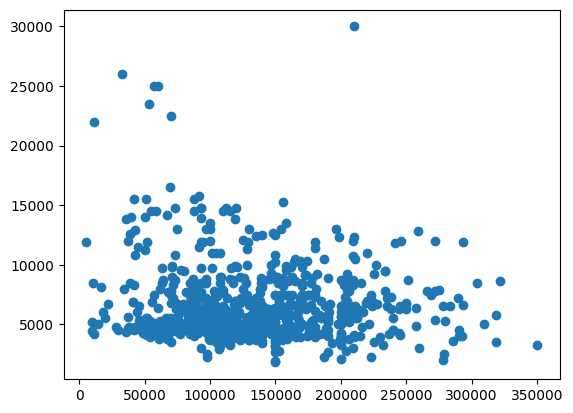

In [35]:
nissan_df = df[df['Brand'] == 'Nissan']

plt.scatter(nissan_df['Mileage'], nissan_df['Price ($)'])
plt.show()

In [36]:
nissan_df[nissan_df['Price ($)'] > 28000]

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
8244,30000,Nissan Patrol,19.11.2019,2011,210000.0,SUV,Automatic,Left,White,Nissan,Patrol


In [37]:
nissan_df[nissan_df['Model'] == 'Patrol']

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
6258,11000,Nissan Patrol,24.11.2019,2000,220000.0,SUV,Automatic,Left,White,Nissan,Patrol
8107,25000,Nissan Patrol,13.11.2019,2004,60000.0,SUV,Automatic,Left,Black,Nissan,Patrol
8244,30000,Nissan Patrol,19.11.2019,2011,210000.0,SUV,Automatic,Left,White,Nissan,Patrol


The last one is an outlier, we will remove it.

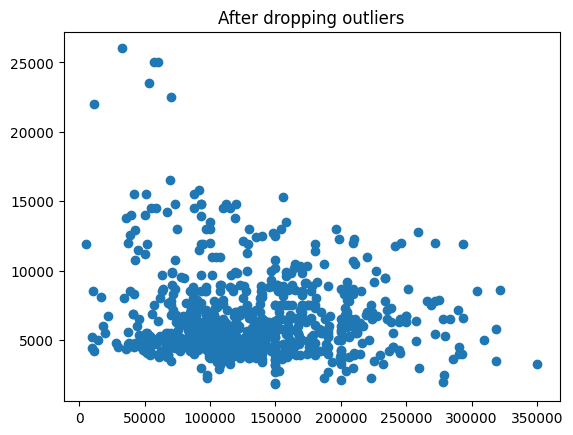

In [38]:
nissan_df = nissan_df[nissan_df['Price ($)'] < 30000]
plt.scatter(nissan_df['Mileage'], nissan_df['Price ($)'])
plt.title('After dropping outliers')
plt.show()

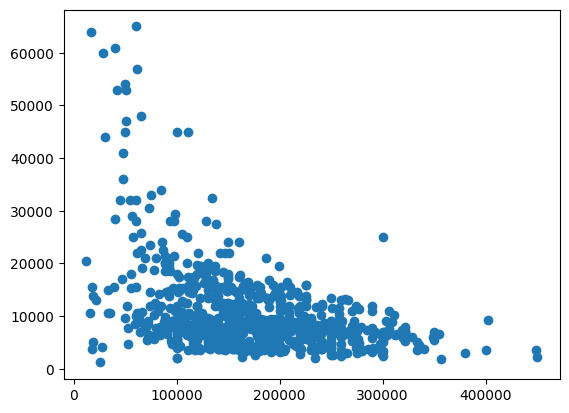

In [39]:
bmw_df = df[df['Brand'] == 'BMW']

plt.scatter(bmw_df['Mileage'], bmw_df['Price ($)'])
plt.show()

according to the schedule, the one with the mileage equal to 30.000 is an outlier

In [40]:
bmw_df[ bmw_df['Price ($)'] > 24000]

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
8109,25000,BMW 530,10.11.2019,2011,58000.00,Sedan,Automatic,Left,White,BMW,530
8114,25000,BMW 520,25.11.2019,1992,300000.00,Sedan,Manual,Left,White,BMW,520
8120,25000,BMW 535,23.11.2019,2011,110000.00,Sedan,Automatic,Left,White,BMW,535
8137,25555,BMW X5,03.12.2019,2013,105000.00,SUV,Automatic,Left,Black,BMW,X5
8141,25800,BMW 750,02.12.2019,2013,65000.00,Sedan,Automatic,Left,Black,BMW,750
8186,27500,BMW X6,24.11.2019,2012,138000.00,Estate,Automatic,Left,Black,BMW,X6
8194,28000,BMW 640,30.11.2019,2013,93000.00,Sedan,Automatic,Left,Gray,BMW,640
8196,28000,BMW 750,25.11.2019,2015,96999.00,Sedan,Automatic,Left,Black,BMW,750
8198,28000,BMW X5,22.11.2019,2013,128000.00,SUV,Automatic,Left,White,BMW,X5
8208,28000,BMW 428,19.11.2019,2013,60000.00,Coupe,Automatic,Left,Black,BMW,428


In [41]:
bmw_df[ bmw_df['Model'] == '520']

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
88,1800,BMW 520,15.11.2019,1992,357000.0,Sedan,Automatic,Left,Black,BMW,520
138,2000,BMW 520,28.11.2019,1991,100000.0,Sedan,Manual,Left,Black,BMW,520
235,2300,BMW 520,29.11.2019,1992,163000.0,Sedan,Manual,Left,Black,BMW,520
293,2500,BMW 520,01.12.2019,1996,300000.0,Sedan,Manual,Left,Silver,BMW,520
642,3000,BMW 520,30.11.2019,1996,265000.0,Sedan,Automatic,Left,Blue,BMW,520
644,3000,BMW 520,30.11.2019,2005,380000.0,Sedan,Manual,Left,Silver,BMW,520
820,3200,BMW 520,23.11.2019,1998,192000.0,Sedan,Automatic,Left,Silver,BMW,520
3590,6800,BMW 520,22.11.2019,2003,235000.0,Sedan,Automatic,Left,Silver,BMW,520
7472,15500,BMW 520,17.11.2019,2013,134000.0,Sedan,Automatic,Left,White,BMW,520
7537,15990,BMW 520,24.11.2019,2014,149000.0,Sedan,Automatic,Left,Black,BMW,520


In [42]:
bmw_df[ bmw_df['Mileage'] == 300000]

,Price ($),Car,Date Posted,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
293,2500,BMW 520,01.12.2019,1996,300000.0,Sedan,Manual,Left,Silver,BMW,520
957,3300,BMW 318,19.11.2019,1998,300000.0,Sedan,Manual,Left,Black,BMW,318
2286,5000,BMW 325,24.11.2019,2003,300000.0,Sedan,Automatic,Left,Black,BMW,325
2693,5500,BMW 330,25.11.2019,2005,300000.0,Sedan,Automatic,Left,Gray,BMW,330
2997,6000,BMW 525,24.11.2019,2003,300000.0,Sedan,Automatic,Left,Silver,BMW,525
3757,7000,BMW X5,29.11.2019,2001,300000.0,SUV,Semi-Automatic,Left,Gray,BMW,X5
8114,25000,BMW 520,25.11.2019,1992,300000.0,Sedan,Manual,Left,White,BMW,520


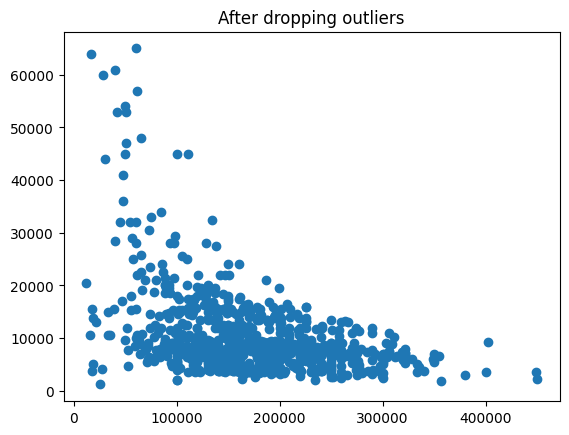

In [43]:
bmw_df = bmw_df[(bmw_df['Price ($)'] != 25000) | (bmw_df['Mileage'] != 300000)]
plt.scatter(bmw_df['Mileage'], bmw_df['Price ($)'])
plt.title('After dropping outliers')
plt.show()

collect these resulting data as a final dataset

In [44]:
final_df = pd.concat([merc_df, toyota_df, opel_df, nissan_df, bmw_df], axis=0)
final_df['Brand'].value_counts()

Mercedes-Benz    1537
Toyota           1215
Opel              950
Nissan            794
BMW               774
Name: Brand, dtype: int64

Let's remove the Date Posted column because we don't need it

In [45]:
final_df = final_df.drop('Date Posted', axis=1)
final_df['Vehicle Type'].value_counts()

Sedan                      2869
SUV                         645
Hatchback                   565
MPV                         561
Estate                      496
Coupe                       105
Van                          17
Convertible or Roadster       7
Pickup                        5
Name: Vehicle Type, dtype: int64

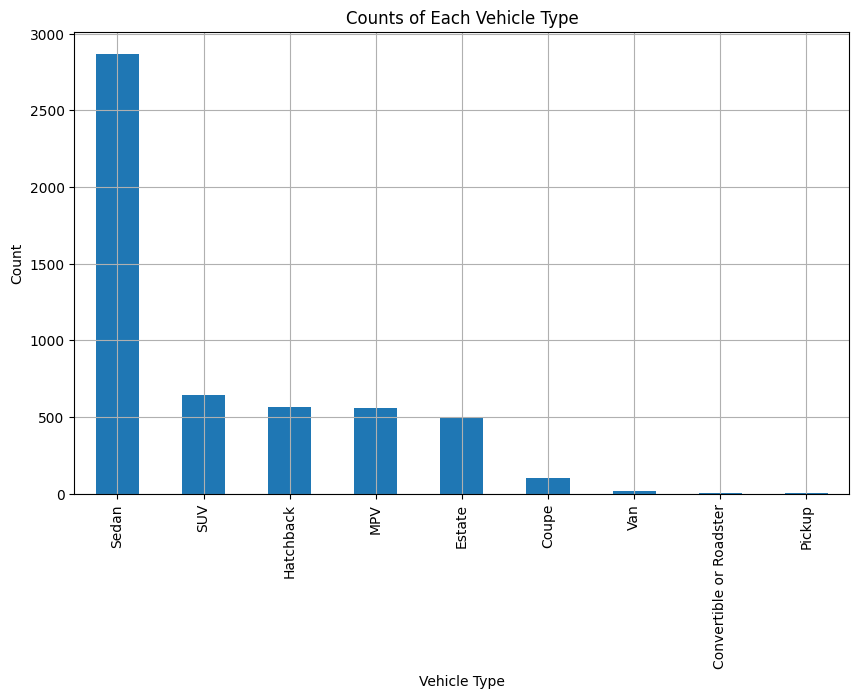

In [46]:
# Group the data by vehicle type and get the counts
vehicle_counts = final_df['Vehicle Type'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
vehicle_counts.plot(kind='bar')
plt.title('Counts of Each Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Since the last four types of cars are very few compared to the first five, we will use the first five.

In [47]:
final_df = final_df[final_df['Vehicle Type'].isin(['Sedan','SUV','MPV','Hatchback','Estate'])]
final_df

,Price ($),Car,Year,Mileage,Vehicle Type,Transmission,Wheel left/right,Color,Brand,Model
27,1500,Mercedes-Benz C 180,1996,240000.0,Sedan,Manual,Left,Blue,Mercedes-Benz,C 180
66,1700,Mercedes-Benz 124,1975,111111.0,Sedan,Manual,Left,Green,Mercedes-Benz,124
82,1750,Mercedes-Benz 180,1996,260000.0,Sedan,Manual,Left,Green,Mercedes-Benz,180
110,1900,Mercedes-Benz A 140,1999,139200.0,Sedan,Automatic,Left,Red,Mercedes-Benz,A 140
129,2000,Mercedes-Benz C 180,1996,235000.0,Sedan,Manual,Left,Blue,Mercedes-Benz,C 180
...,...,...,...,...,...,...,...,...,...,...
8499,57000,BMW X6,2015,61000.0,SUV,Automatic,Left,White,BMW,X6
8503,60000,BMW 750,2015,28821.0,Sedan,Automatic,Left,White,BMW,750
8506,61000,BMW 750,2015,40000.0,Sedan,Automatic,Left,Black,BMW,750
8510,64000,BMW X6,2017,17000.0,SUV,Automatic,Left,White,BMW,X6


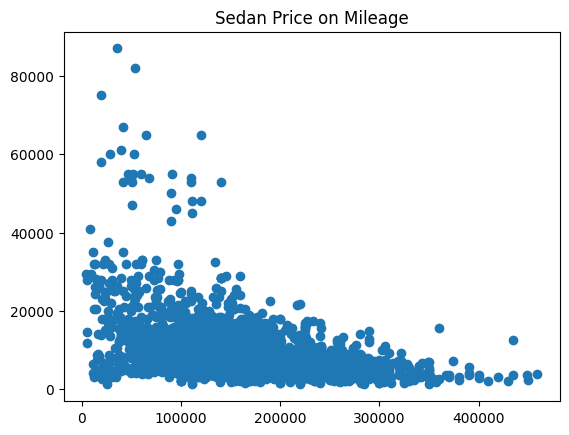

In [48]:
sedan = final_df[final_df['Vehicle Type'] == 'Sedan']

plt.scatter(sedan['Mileage'], sedan['Price ($)'])
plt.title('Sedan Price on Mileage')
plt.show()

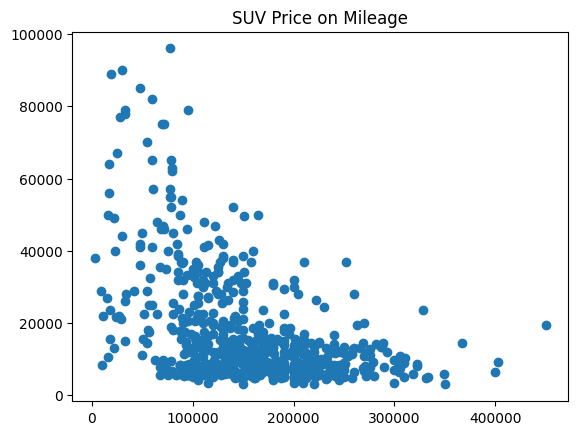

In [49]:
suv = final_df[final_df['Vehicle Type'] == 'SUV']

plt.scatter(suv['Mileage'], suv['Price ($)'])
plt.title('SUV Price on Mileage')
plt.show()

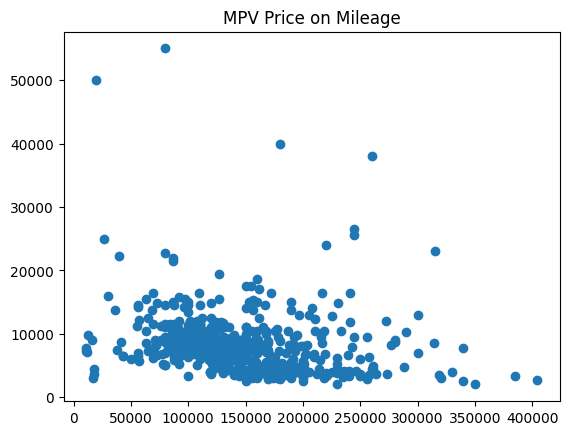

In [50]:
mpv = final_df[final_df['Vehicle Type'] == 'MPV']

plt.scatter(mpv['Mileage'], mpv['Price ($)'])
plt.title('MPV Price on Mileage')
plt.show()

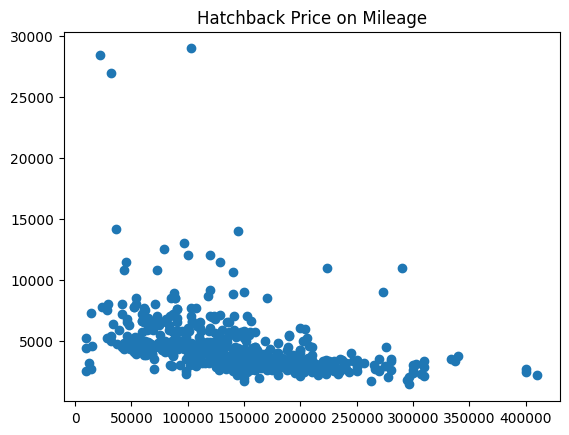

In [51]:
hatch = final_df[final_df['Vehicle Type'] == 'Hatchback']

plt.scatter(hatch['Mileage'], hatch['Price ($)'])
plt.title('Hatchback Price on Mileage')
plt.show()


Now consider the new dataset and perform One hot encoding for the following columns: Transmission, Vehicle Type, Brand, Wheel left/right

In [52]:
columns_to_encode = ['Transmission', 'Vehicle Type', 'Brand','Wheel left/right']
one_hot_encoded = pd.get_dummies(final_df[columns_to_encode])

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([final_df, one_hot_encoded], axis=1)

# Drop the original columns from the DataFrame
df_encoded = df_encoded.drop(columns_to_encode, axis=1)
df_encoded

,Price ($),Car,Year,Mileage,Color,Model,Transmission_Automatic,Transmission_Manual,Transmission_Semi-Automatic,Transmission_Variator,...,Vehicle Type_SUV,Vehicle Type_Sedan,Brand_BMW,Brand_Mercedes-Benz,Brand_Nissan,Brand_Opel,Brand_Toyota,Wheel left/right_Changed l->R,Wheel left/right_Left,Wheel left/right_Right
27,1500,Mercedes-Benz C 180,1996,240000.0,Blue,C 180,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
66,1700,Mercedes-Benz 124,1975,111111.0,Green,124,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
82,1750,Mercedes-Benz 180,1996,260000.0,Green,180,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
110,1900,Mercedes-Benz A 140,1999,139200.0,Red,A 140,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
129,2000,Mercedes-Benz C 180,1996,235000.0,Blue,C 180,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8499,57000,BMW X6,2015,61000.0,White,X6,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
8503,60000,BMW 750,2015,28821.0,White,750,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
8506,61000,BMW 750,2015,40000.0,Black,750,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
8510,64000,BMW X6,2017,17000.0,White,X6,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0


Looking at the correlations.

C:\Users\davoy\AppData\Local\Temp\ipykernel_15612\3203130815.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_encoded.corr(),annot=True)


<Axes: >

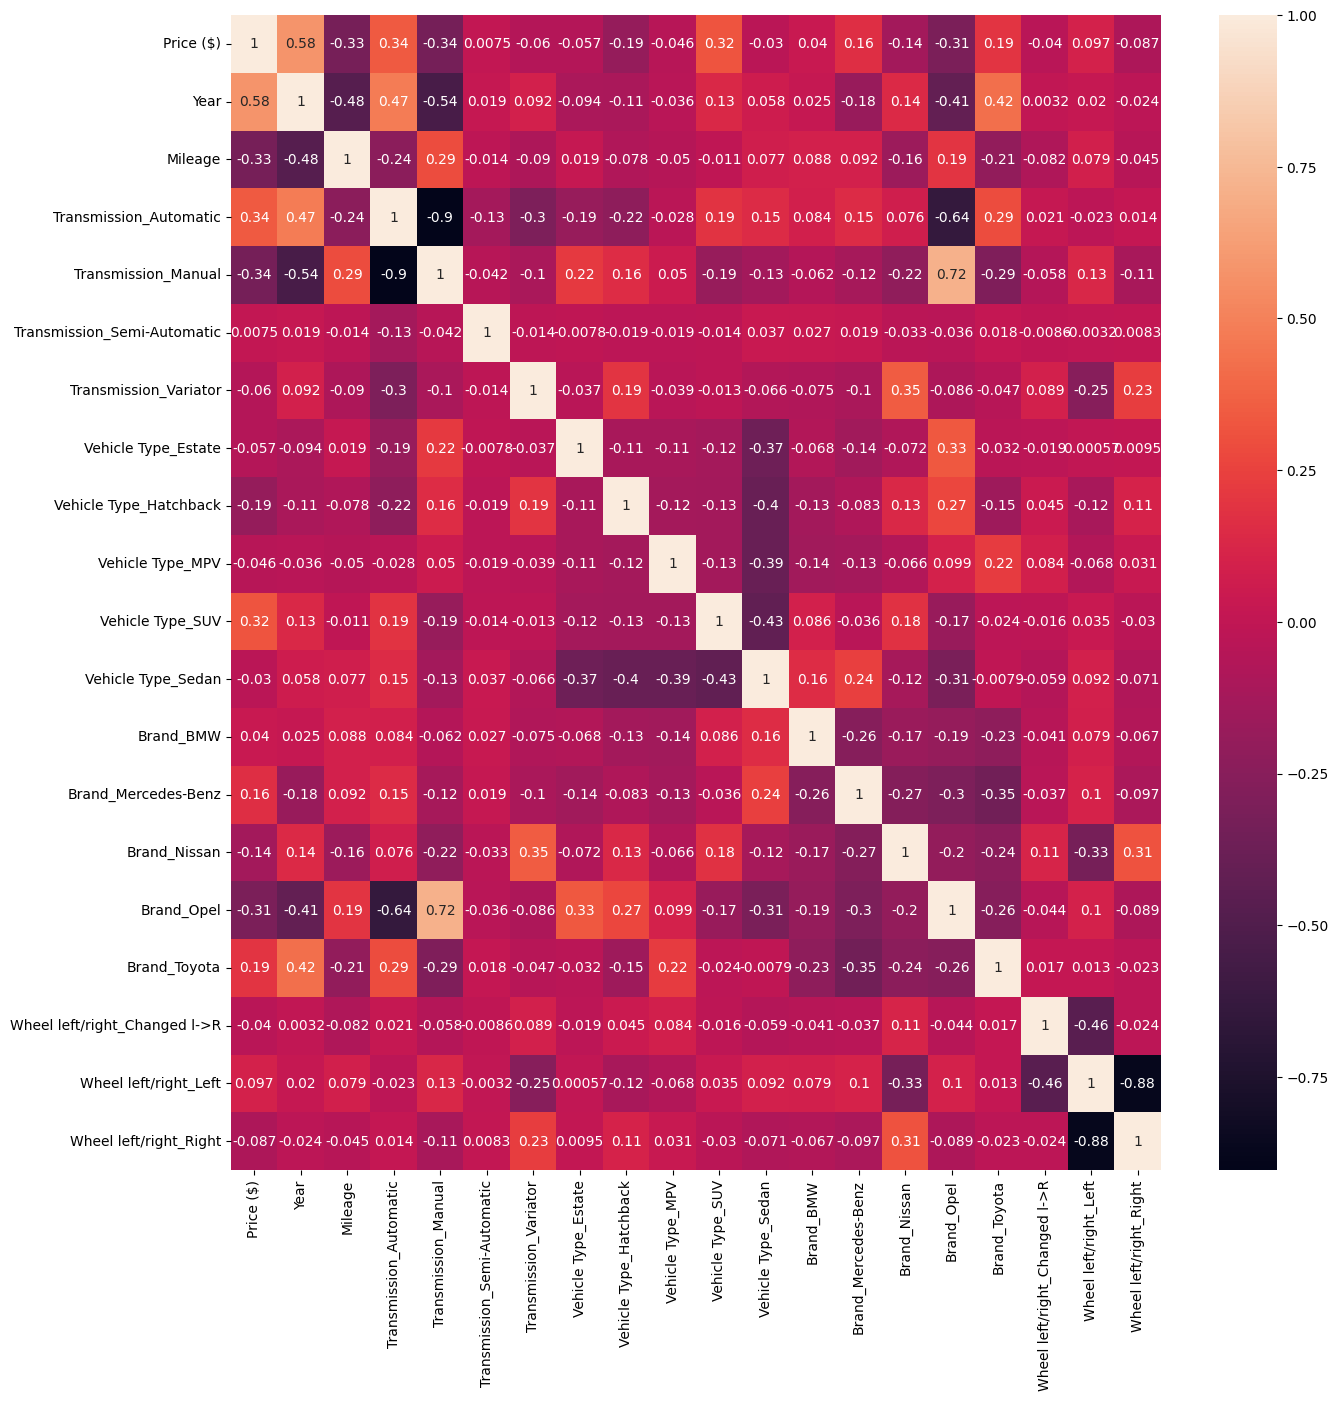

In [53]:
plt.figure(figsize=[15,15])
sns.heatmap(df_encoded.corr(),annot=True)

In [54]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5136 entries, 27 to 8516
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Price ($)                      5136 non-null   int64  
 1   Car                            5136 non-null   object 
 2   Year                           5136 non-null   int64  
 3   Mileage                        5136 non-null   float64
 4   Color                          5136 non-null   object 
 5   Model                          5136 non-null   object 
 6   Transmission_Automatic         5136 non-null   uint8  
 7   Transmission_Manual            5136 non-null   uint8  
 8   Transmission_Semi-Automatic    5136 non-null   uint8  
 9   Transmission_Variator          5136 non-null   uint8  
 10  Vehicle Type_Estate            5136 non-null   uint8  
 11  Vehicle Type_Hatchback         5136 non-null   uint8  
 12  Vehicle Type_MPV               5136 non-null   

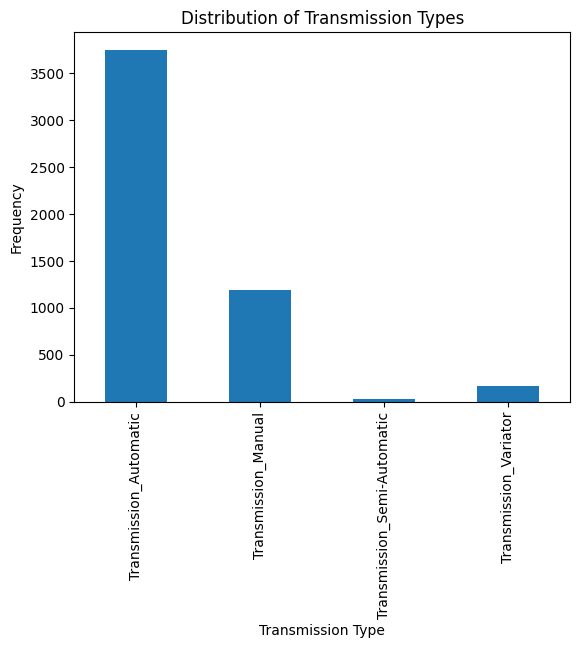

In [55]:
df_encoded.iloc[:, 6:10].sum().plot(kind='bar')
plt.xlabel('Transmission Type')
plt.ylabel('Frequency')
plt.title('Distribution of Transmission Types')
plt.show()

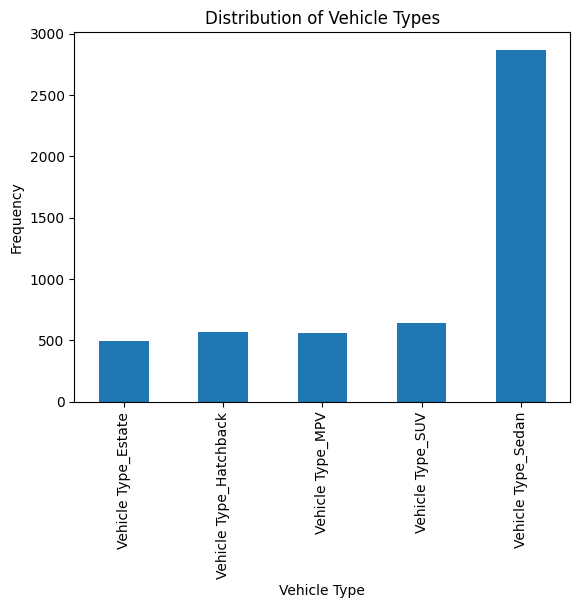

In [57]:
df_encoded.iloc[:, 10:15].sum().plot(kind='bar')
plt.xlabel('Vehicle Type')
plt.ylabel('Frequency')
plt.title('Distribution of Vehicle Types')
plt.show()

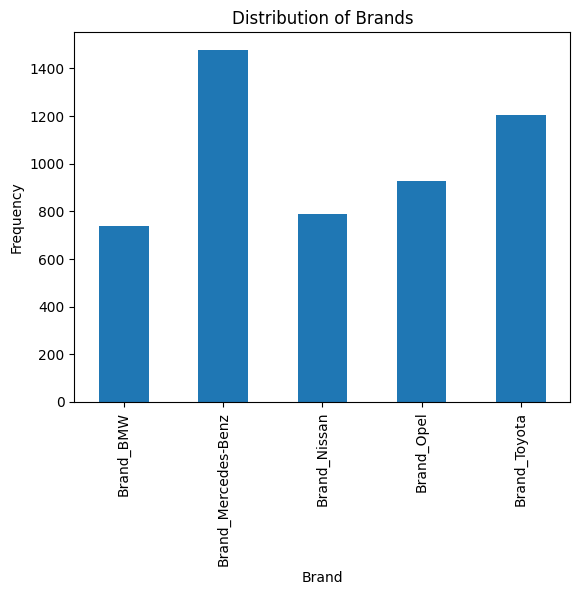

In [59]:
df_encoded.iloc[:, 15:20].sum().plot(kind='bar')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.title('Distribution of Brands')
plt.show()

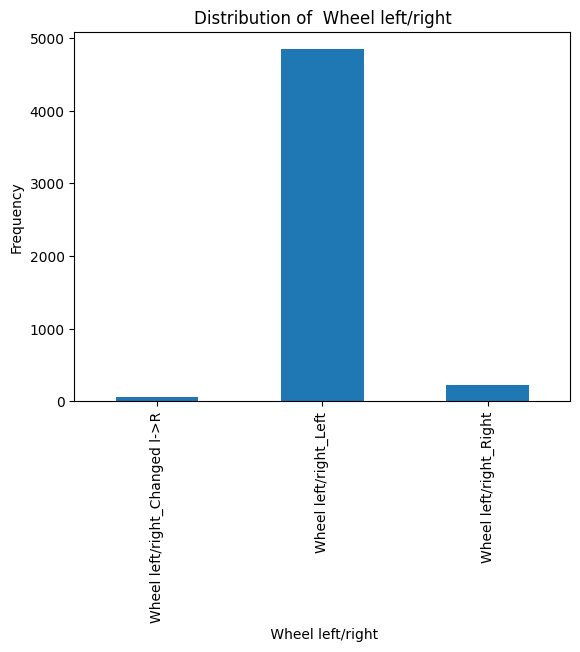

In [60]:
df_encoded.iloc[:, 20:].sum().plot(kind='bar')
plt.xlabel(' Wheel left/right')
plt.ylabel('Frequency')
plt.title('Distribution of  Wheel left/right')
plt.show()

Let's see the importance of the feautures.

In [58]:
# importances
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Calculate permutation importances
perm_importances = PermutationImportance(model).fit(X_test, y_test)

# Display permutation importances
eli5.show_weights(perm_importances, feature_names=X_test.columns.tolist())


Weight,Feature
0.8063 ± 0.0753,Year
0.3737 ± 0.1582,Brand_Mercedes-Benz
0.2511 ± 0.0403,Vehicle Type_SUV
0.1013 ± 0.0550,Mileage
0.0885 ± 0.0207,Brand_Nissan
0.0678 ± 0.0314,Brand_BMW
0.0372 ± 0.0038,Vehicle Type_Hatchback
0.0229 ± 0.0115,Vehicle Type_Estate
0.0112 ± 0.0051,Brand_Toyota
0.0103 ± 0.0033,Brand_Opel


In [69]:
# Create bins for the target variable 'Price ($)'
df_encoded['Price Category'] = pd.qcut(df_encoded['Price ($)'], q=3, labels=['Low', 'Medium', 'High'])
# Split the data into training and testing setsX = df_encoded.drop(['Price ($)', 'Price Category'], axis=1)
y = df_encoded['Price Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a Random Forest classifier and fit the model to the training data
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
# Predict the target variable for the test data
y_pred = rf.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7665369649805448


In [70]:
df_encoded['Price Category'].value_counts()


Low       1770
High      1695
Medium    1671
Name: Price Category, dtype: int64

We can see that the price categories are evenly distributed

The final data on which we will work is ready. We can start performing different regressions in order to understand which one is more suitable and effective.

The first is linear regression

In [59]:
# linear regression for df
# df_reg = df_encoded[]
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the trained model
y_pred = model.predict(X_test)

# Evaluate the model using mean squared error (MSE)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 36288942.955414504
RMSE: 6024.03045770973
MAE: 3545.724478558294
R-squared: 0.5363507798786928


The r-squared is 0.536, which means that the results obtained by linear regression are approximately 50% reliable. This regression is not good for our data.

Let's preform radom forest regression

In [60]:
# radom forest for df

# Split the data into features (X) and target variable (y)
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 21958313.475218106
RMSE: 4685.9698542797
MAE: 2122.381884781669
R-squared: 0.7194474655689851


r-squared is 0.72, which means that the results obtained through linear regression are approximately 72% reliable, which is already a better result.

knn regression

In [61]:
# knn

# Split the data into features (X) and target variable (y)
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a KNN regression model
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluate the model
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


MSE: 19418612.783112843
RMSE: 4406.655509920516
MAE: 2064.7136186770426
R-squared: 0.7518961992420186


The r-squared is 0.75, which means that the results obtained by knn regression are approximately 75% reliable, which is a better result.

Mean Squared Error: 70266505.91533585


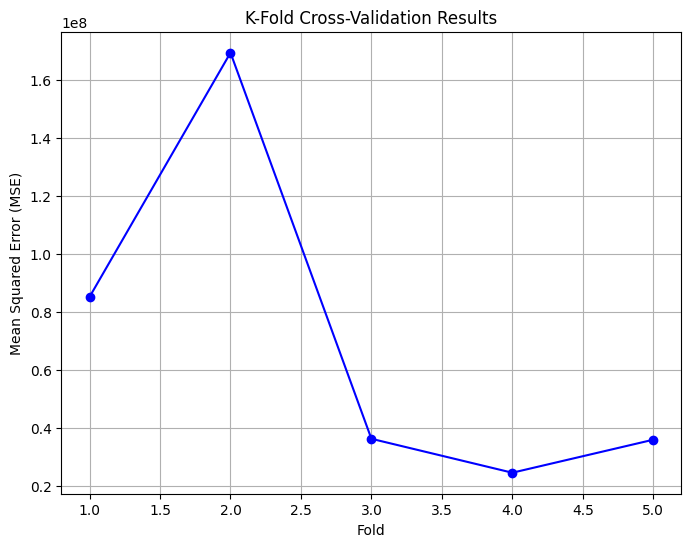

In [62]:
# Perform k-fold cross-validation and obtain MSE scores
k = 5  # Number of folds
mse_scores = -cross_val_score(model, X, y, cv=k, scoring='neg_mean_squared_error')

# Compute mean MSE value across folds
mean_mse = np.mean(mse_scores)

# Print the mean MSE value
print("Mean Squared Error:", mean_mse)

# Plotting the MSE values
plt.figure(figsize=(8, 6))
plt.plot(range(1, k + 1), mse_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('K-Fold Cross-Validation Results')
plt.grid(True)
plt.show()


try KNN with k=4

In [63]:
# knn model with 4 neighbors

# Split the data into features (X) and target variable (y)
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a KNN regression model
knn_model = KNeighborsRegressor(n_neighbors=4)

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluate the model
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 18993495.9036965
RMSE: 4358.152808667509
MAE: 2106.329766536965
R-squared: 0.7573277465274812


R-squared increased

xgboost regression

In [64]:
# xgboost regression

# Split the data into features (X) and target variable (y)
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost Regressor model
xgb_model = xgb.XGBRegressor(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 24814404.889470264
RMSE: 4981.405914947131
MAE: 2236.001626515667
R-squared: 0.682956334966472


The result got worse

Let's try Decision Tree Regression

In [65]:
# Select the features (X) and the target variable (y)
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


MSE: 36460129.76240272
RMSE: 6038.222400872853
MAE: 2659.066634241245
R-squared: 0.534163594937741


We got the same result as in linear regression

polynomial regression

In [66]:
# Select the features (X) and the target variable (y)
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features
degree = 3  # Set the degree of the polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Create a linear regression model
model = LinearRegression()

# Train the model using the polynomial features
model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_poly)

# Evaluate the model's performance
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


MSE: 23732990.662934262
RMSE: 4871.651738674909
MAE: 2712.22652399237
R-squared: 0.6967731293376263


Again the result is no more than the knn we got before.

Voting Regression

In [67]:
# Select the features (X) and the target variable (y)
X = df_encoded.drop(['Price ($)', 'Car','Color','Model'], axis=1)
y = df_encoded['Price ($)']
# Define the individual regression models
model1 = LinearRegression()
model2 = DecisionTreeRegressor()
model3 = KNeighborsRegressor()

# Create the voting regression model
voting_model = VotingRegressor([('linear', model1), ('tree', model2), ('knn', model3)])

# Fit the voting regression model to the data
voting_model.fit(X, y)

# Make predictions
y_pred = voting_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


MSE: 14611326.033144724
RMSE: 3822.4764267611545
MAE: 1996.0425584220877
R-squared: 0.8133169674154175


Voting Regression improved prediction accuracy by exploiting the strengths of different regression models.

In [68]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Select the features (X) and the target variable (y)
X = df_encoded.drop(['Price ($)', 'Car', 'Color', 'Model'], axis=1)
y = df_encoded['Price ($)']

# Define the individual regression models
model1 = LinearRegression()
model2 = DecisionTreeRegressor()

# Create the voting regression model
voting_model = VotingRegressor([('linear', model1), ('tree', model2)])

# Create the bagging regressor with the voting model as the base estimator
bagging_model = BaggingRegressor(base_estimator=voting_model, n_estimators=10, random_state=42)

# Fit the bagging regressor to the data
bagging_model.fit(X, y)

# Make predictions
y_pred = bagging_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


C:\Users\davoy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


MSE: 13925753.943041682
RMSE: 3731.7226508734116
MAE: 2060.08235632517
R-squared: 0.8220762461109624
